In [1]:
import autograd
import autograd.numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from matplotlib import colors, cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from pyDOE import lhs
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky
from scipy.linalg import solve
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from src.mintGP import mintGP
from scipy.optimize import minimize, basinhopping, differential_evolution, brute
import scipy.io as sio
import copy
from src.modules.AMOGAPE import AMOGAPE
from src.modules.GENSYNDATA import *
import pyrcel as pm
import random
from scipy.stats import truncnorm
import os
%matplotlib inline

/Users/muszynski/opt/anaconda3/envs/gp_emu_test/lib/python3.10/site-packages/pyrcel/_parcel_aux_numba.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module
  from numba.pycc import CC


## Apply to pyrcel data: X={draft velocity, aerosol concentration}; Y={parcel supersaturation}

In [2]:
def model(X):
    X_size = X.shape
    print('model input size:', X_size)
    print('X', X)

    onedim_output = []
     
    # Input params
    V = X[0][0]
    AC = X[0][1]
        
    # Fixed
    P0 = 77500. # Pressure, Pa
    T0 = 274.   # Temperature, K
    S0 = -0.02  # Supersaturation, 1-RH (98% here)
    
    sulfate =  pm.AerosolSpecies('sulfate', pm.Lognorm(mu=0.015, sigma=1.6, N=AC),
                                 kappa=0.54, bins=200)
    
    initial_aerosols = [sulfate]
        
    dt = 1.0 # timestep, seconds
    t_end = 250./V # end time, seconds... 250 meter simulation
        
    model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
    parcel_trace, aerosol_traces = model.run(t_end, dt, solver="cvode")
                
    s = parcel_trace['wc'].to_numpy(dtype='float64')
    mu = np.mean(s)
    #onedim_output.append(mu)
    #arr = np.expand_dims(s, axis=1)
    #print('onedim_output', arr.shape)
    #onedim_output.append(np.mean(arr))
    
    tmp = np.array([mu])
    out = np.expand_dims(tmp, axis=1)
    print('model output size', out.shape)
        
    return out

def pyrcel_model(X):

    X_size = X.shape
    print(X_size)

    onedim_output = []
    
    for pv in X:
        print('x1,x1:',pv)
        
        # Input params
        V = pv[0]
        AC = pv[1]
        
        # Fixed
        P0 = 77500. # Pressure, Pa
        T0 = 274.   # Temperature, K
        S0 = -0.02  # Supersaturation, 1-RH (98% here)
    
        sulfate =  pm.AerosolSpecies('sulfate',
                                 pm.Lognorm(mu=0.015, sigma=1.6, N=AC),
                                 kappa=0.54, bins=200)
    
        initial_aerosols = [sulfate]
        
        dt = 1.0 # timestep, seconds
        t_end = 250./V # end time, seconds... 250 meter simulation
        
        model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
        parcel_trace, aerosol_traces = model.run(t_end, dt, solver="cvode")
                
        s = parcel_trace['wc'].to_numpy(dtype='float64')
        mu = np.mean(s)
        onedim_output.append(mu)
        #arr = np.expand_dims(s, axis=1)
        #print('onedim_output', arr.shape)
        #onedim_output.append(np.mean(arr))
    
    tmp = np.array(onedim_output)
    out = np.expand_dims(tmp, axis=1)
    print(out.shape)
        
    return out

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def gen_input_samples(M):
    
    # Input params
    #V updraft speed, m/s
    #AC aerosol concentration

    V = []
    AC = []

    xV = get_truncated_normal(mean=2, sd=2, low=1, upp=20)
    V = xV.rvs(M)

    xAC = get_truncated_normal(mean=8, sd=2, low=50, upp=150)
    AC = xAC.rvs(M)
    
    return np.vstack((V,AC)).T
    
    '''
    for i in range(0,M):
        V.append(random.randrange(1,20))
        #AC.append(random.randrange(1,20))
        AC.append(random.randrange(250,850))
    
    return np.array([V,AC]).T
    '''

def load_data(name):
    npz = np.load(name)
    Xt = npz['arr_0']
    Yt = npz['arr_1']
    return Xt,Yt

def lhs_generate_input_data(lims, n, dim=2):
    diffs = np.diff(lims)
    Xt = lhs(dim, n)*diffs.T + lims[:,0].T 
    return Xt

def plot_all(limitscale):
    
    fig = plt.figure(figsize=[18,8])

    #===============
    # X data
    #===============
    ax = fig.add_subplot(1, 3, 1)
    ax.scatter(amo.data['X'][:,0], amo.data['X'][:,1], alpha=0.2, c='green')
    ax.scatter(Xt[:,0], Xt[:,1], alpha=1, s=50, c='red')
    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2)
    ax.set_xlim(lims[0]), ax.set_ylim(lims[1])
    ax.set_title("Input data")
    
    #===============
    # Fit
    #===============
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    
    M = 50; 
    grid0 = np.linspace(lims[0][0],lims[0][1],M).reshape(M,1); 
    grid1 = np.linspace(lims[1][0],lims[1][1],M).reshape(M,1);
    XX1,XX2 = np.meshgrid(grid0,grid1)
    
    # amo.emudict['emu0'] I will have many emulator if P >= 2 and need to change 'emuXXX'.
    Z = [[amo.emudict['emu0'].predict( np.array([XX1[i,j], XX2[i,j] ]).reshape(1,2) )[0,0] for i in range(M)] for j in range(M)]
    Z = np.array(Z).T
    
    ax.plot_surface(XX1, XX2, Z, rstride=1, cstride=1, alpha=0.3, cmap='jet')
    #ax.scatter3D(XX1, XX2, Z, marker='.', alpha=0.4, c='r')
    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2) 
    ax.set_zlabel(name_out_var, labelpad=1.), 
    
    #===============
    #  Acquisition function
    #===============
    ax = fig.add_subplot(1, 3, 3)
    
    M = 30
    lim0 = np.linspace(lims[0][0],lims[0][1],M)
    lim1 = np.linspace(lims[1][0],lims[1][1], M)
    x0, x1 = np.meshgrid(lim0, lim1)
    ack = [[ np.float64( acq(np.array([[ x0[i, j], x1[i, j] ]])).item() )
            for i in range(M)] for j in range(M)]
    ack = np.array(ack).T
    #print('ACK', ack)
    im=ax.imshow(ack, origin='lower',extent=[lims[0][0],lims[0][1],lims[1][0],lims[1][1]], interpolation='gaussian', aspect='auto')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    #cax = fig.add_axes([0.67, 0.1, 0.5, 0.05])
    #fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2) 
    ax.set_title("Acqusition function A(x)")
    
    # Update
    new = amo.update(limitscale, acq)
    print( amo.emudict['emu0'].likelihood_variance )
    ax.scatter(new[0],new[1],s=70,color='magenta',alpha=1)
    
    print('RMSE: ',amo.test(Xt,Yt))
    plt.show()

def plot_fit(amo, Xt, lims, name_param1, name_param2, name_out_var):
    
    fig = plt.figure(figsize=[12,8])

    #===============
    # X data
    #===============
    ax = fig.add_subplot(1, 3, 1)
    ax.scatter(amo.data['X'][:,0], amo.data['X'][:,1], alpha=0.2, c='green')
    ax.scatter(Xt[:,0], Xt[:,1], alpha=1, s=30, c='red')
    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2)
    ax.set_xlim(lims[0]), ax.set_ylim(lims[1])
    ax.set_title("Input data")
    
    #===============
    # Fit
    #===============
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    
    M = Xt.shape[0]; 
    grid0 = np.linspace(lims[0][0],lims[0][1],M).reshape(M,1); 
    grid1 = np.linspace(lims[1][0],lims[1][1],M).reshape(M,1);
    XX1,XX2 = np.meshgrid(grid0,grid1)
    
    # amo.emudict['emu0'] I will have many emulator if P >= 2 and need to change 'emuXXX'.
    Z = [[amo.emudict['emu0'].predict( np.array([XX1[i,j], XX2[i,j] ]).reshape(1,2) )[0,0] for i in range(M)] for j in range(M)]
    Z = np.array(Z).T

    ax.plot_surface(XX1, XX2, Z, rstride=1, cstride=1, alpha=0.3, cmap='jet')
    #ax.scatter3D(XX1, XX2, Z, marker='.', alpha=0.4, c='r')

    #am1,am2 = np.meshgrid(amo.data['X'][:,0], amo.data['X'][:,1])
    #ax.scatter3D(am1, am2,  alpha=1, s=30, c='red')

    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2) 
    ax.set_zlabel(name_out_var, labelpad=1.), 
    plt.show()

In [3]:
n_exp = 5#104
name_param1 = 'Total number concentration [1/cm^3]'
name_param2 = 'Updraft speed [m/s]'
name_out_var = 'Supersaturation (1-RH) [%]'
lims = np.array([[0.5,6],[800,1000]])
N = 30

exp_setup = ['exp', str(n_exp), 'XY', str(N), 'data', '.npz']
exp_name = '_'.join(exp_setup)
print(exp_name)

if os.path.isfile('./'+exp_name):
    Xt, Yt = load_data(exp_name)
    print('loaded data...', Xt.shape, Yt.shape)
else:
    Xt = lhs_generate_input_data(lims, N)
    Yt = pyrcel_model(Xt)
    np.savez(exp_name, Xt, Yt)
    print('generated data...', Xt.shape, Yt.shape)

exp_5_XY_30_data_.npz
(30, 2)
x1,x1: [  2.90819765 993.969268  ]


/Users/muszynski/opt/anaconda3/envs/gp_emu_test/lib/python3.10/site-packages/pyrcel/integrator.py:30: UserWarning: Could not import odespy package; invoking the 'lsoda' or 'lsode' options will fail!
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


x1,x1: [  3.4397406  870.90214966]
x1,x1: [  3.72244203 902.59226287]
x1,x1: [  1.38156616 806.28373303]
x1,x1: [  2.76405018 935.04168911]
x1,x1: [  0.89033311 844.73769392]
x1,x1: [  5.90827019 808.77559085]
x1,x1: [  2.05705373 847.49669431]
x1,x1: [  5.11527209 888.66849126]
x1,x1: [  3.81196779 980.38265471]
x1,x1: [  2.49242312 979.03703447]
x1,x1: [  2.16904613 825.68088653]
x1,x1: [  5.70754591 947.90361699]
x1,x1: [  3.27051004 837.82736436]
x1,x1: [  4.79855315 899.92503073]
x1,x1: [  3.23818742 927.66371019]
x1,x1: [  4.93714012 986.7761351 ]
x1,x1: [6.21946152e-01 8.13510229e+02]
x1,x1: [  5.35756145 878.55916882]
x1,x1: [  4.38263894 883.77240346]
x1,x1: [  4.0538978  964.74863009]
x1,x1: [  5.45430548 917.14800367]
x1,x1: [  4.6345666  972.15873467]
x1,x1: [  1.87373578 862.25244908]
x1,x1: [  1.73595646 832.07818764]
x1,x1: [8.31081487e-01 9.06951925e+02]
x1,x1: [  1.12947231 953.33365898]
x1,x1: [  4.28393772 922.36882036]
x1,x1: [  1.5261219  854.48405162]
x1,x1: [  2.

In [4]:
Xt

array([[2.90819765e+00, 9.93969268e+02],
       [3.43974060e+00, 8.70902150e+02],
       [3.72244203e+00, 9.02592263e+02],
       [1.38156616e+00, 8.06283733e+02],
       [2.76405018e+00, 9.35041689e+02],
       [8.90333106e-01, 8.44737694e+02],
       [5.90827019e+00, 8.08775591e+02],
       [2.05705373e+00, 8.47496694e+02],
       [5.11527209e+00, 8.88668491e+02],
       [3.81196779e+00, 9.80382655e+02],
       [2.49242312e+00, 9.79037034e+02],
       [2.16904613e+00, 8.25680887e+02],
       [5.70754591e+00, 9.47903617e+02],
       [3.27051004e+00, 8.37827364e+02],
       [4.79855315e+00, 8.99925031e+02],
       [3.23818742e+00, 9.27663710e+02],
       [4.93714012e+00, 9.86776135e+02],
       [6.21946152e-01, 8.13510229e+02],
       [5.35756145e+00, 8.78559169e+02],
       [4.38263894e+00, 8.83772403e+02],
       [4.05389780e+00, 9.64748630e+02],
       [5.45430548e+00, 9.17148004e+02],
       [4.63456660e+00, 9.72158735e+02],
       [1.87373578e+00, 8.62252449e+02],
       [1.735956

In [5]:
Xt[:,0]

array([2.90819765, 3.4397406 , 3.72244203, 1.38156616, 2.76405018,
       0.89033311, 5.90827019, 2.05705373, 5.11527209, 3.81196779,
       2.49242312, 2.16904613, 5.70754591, 3.27051004, 4.79855315,
       3.23818742, 4.93714012, 0.62194615, 5.35756145, 4.38263894,
       4.0538978 , 5.45430548, 4.6345666 , 1.87373578, 1.73595646,
       0.83108149, 1.12947231, 4.28393772, 1.5261219 , 2.62463376])

In [6]:
np.mean(Xt[:,0])

3.237405175904157

In [7]:
# Input dimension
D=2
#Output dimension
P=1

#means=np.array([3.5,940]); stdevs=np.array([1.5,855])
means=np.array([np.mean(Xt[:,0]),np.mean(Xt[:,1])]); stdevs=np.array([np.std(Xt[:,0]),np.std(Xt[:,1])])
print(means, stdevs)

startdata={}
startdata['X']=Xt
startdata['Y']=Yt #*1000 # I need to scale this and the output of model(x), but I forgot to do that.

amo = AMOGAPE(model, D=D, P=P, means=means, stdevs=stdevs, inputlimits=lims, startdata=startdata)
#acq = amo.A_add_D_add_G
acq = amo.A_prod_D_prod_G

[  3.23740518 899.52467396] [ 1.57053802 57.06508776]


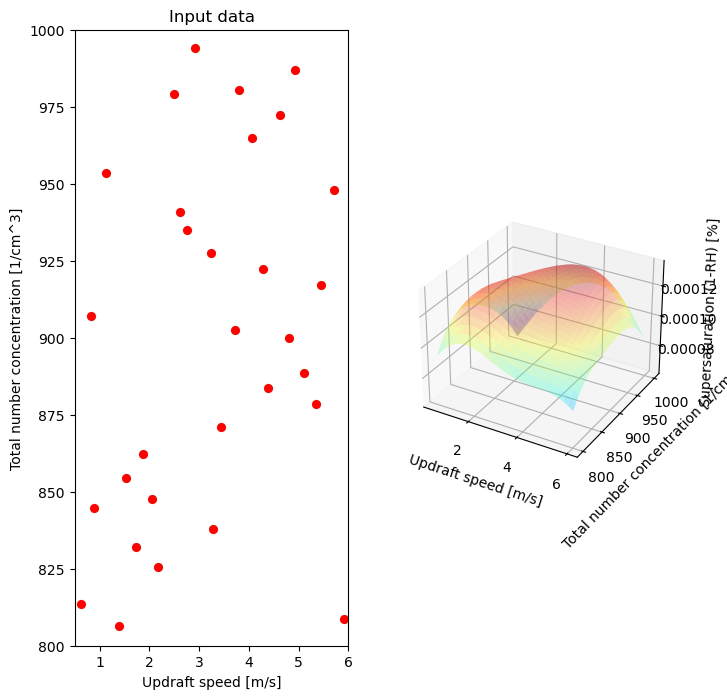

In [8]:
plot_fit(amo, Xt, lims, name_param1, name_param2, name_out_var)

In [9]:
limitscale = 1.0
for run in range(10):    
    # Update
    new = amo.update(limitscale, acq)
    print( amo.emudict['emu0'].likelihood_variance )
    print('RMSE: ',amo.test(Xt,Yt))

LIM: [[0.]
 [0.]]
negA <function AMOGAPE.update.<locals>.<lambda> at 0x7f87f3c11ea0>
sol x: [  1.02889031 908.97418058]
model input size: (1, 2)
X [[  1.02889031 908.97418058]]
model output size (1, 1)
DIV: 1.0909472876924224
GEO: 2.0913741379846262e-05
{31: {'G': 2.0913741379846262e-05, 'D': 1.0909472876924224, 'lengthscale': [1.20452767374036], 'likelihood_sigma': [0.8469007355501258]}}
0.8469007355501258
RMSE:  1.6676525075873027e-05
LIM: [[0.]
 [0.]]
negA <function AMOGAPE.update.<locals>.<lambda> at 0x7f87c2d625f0>
sol x: [  1.29976319 923.63923407]
model input size: (1, 2)
X [[  1.29976319 923.63923407]]
model output size (1, 1)
DIV: 1.024006874987374
GEO: 1.7029770494370822e-05
{31: {'G': 2.0913741379846262e-05, 'D': 1.0909472876924224, 'lengthscale': [1.20452767374036], 'likelihood_sigma': [0.8469007355501258]}, 32: {'G': 1.7029770494370822e-05, 'D': 1.024006874987374, 'lengthscale': [1.2062456324074136], 'likelihood_sigma': [0.840907221485096]}}
0.840907221485096
RMSE:  1.6495

LIM: [[0.]
 [0.]]
negA <function AMOGAPE.update.<locals>.<lambda> at 0x7f87c2dd31c0>
sol x: [  5.41462545 908.74596141]
model input size: (1, 2)
X [[  5.41462545 908.74596141]]
model output size (1, 1)
DIV: 0.9371256997093342
GEO: 1.545128957211655e-05
{31: {'G': 2.0913741379846262e-05, 'D': 1.0909472876924224, 'lengthscale': [1.20452767374036], 'likelihood_sigma': [0.8469007355501258]}, 32: {'G': 1.7029770494370822e-05, 'D': 1.024006874987374, 'lengthscale': [1.2062456324074136], 'likelihood_sigma': [0.840907221485096]}, 33: {'G': 1.685337804683819e-05, 'D': 0.987826373297713, 'lengthscale': [1.216425615813953], 'likelihood_sigma': [0.8372105537207125]}, 34: {'G': 2.0299526276677073e-05, 'D': 0.9825459521196969, 'lengthscale': [1.2125779644536507], 'likelihood_sigma': [0.8305825247835339]}, 35: {'G': 1.931289275879545e-05, 'D': 0.9532681080721284, 'lengthscale': [1.218593786448195], 'likelihood_sigma': [0.8271539518508827]}, 36: {'G': 1.8767452693907247e-05, 'D': 0.9909347359029119, '

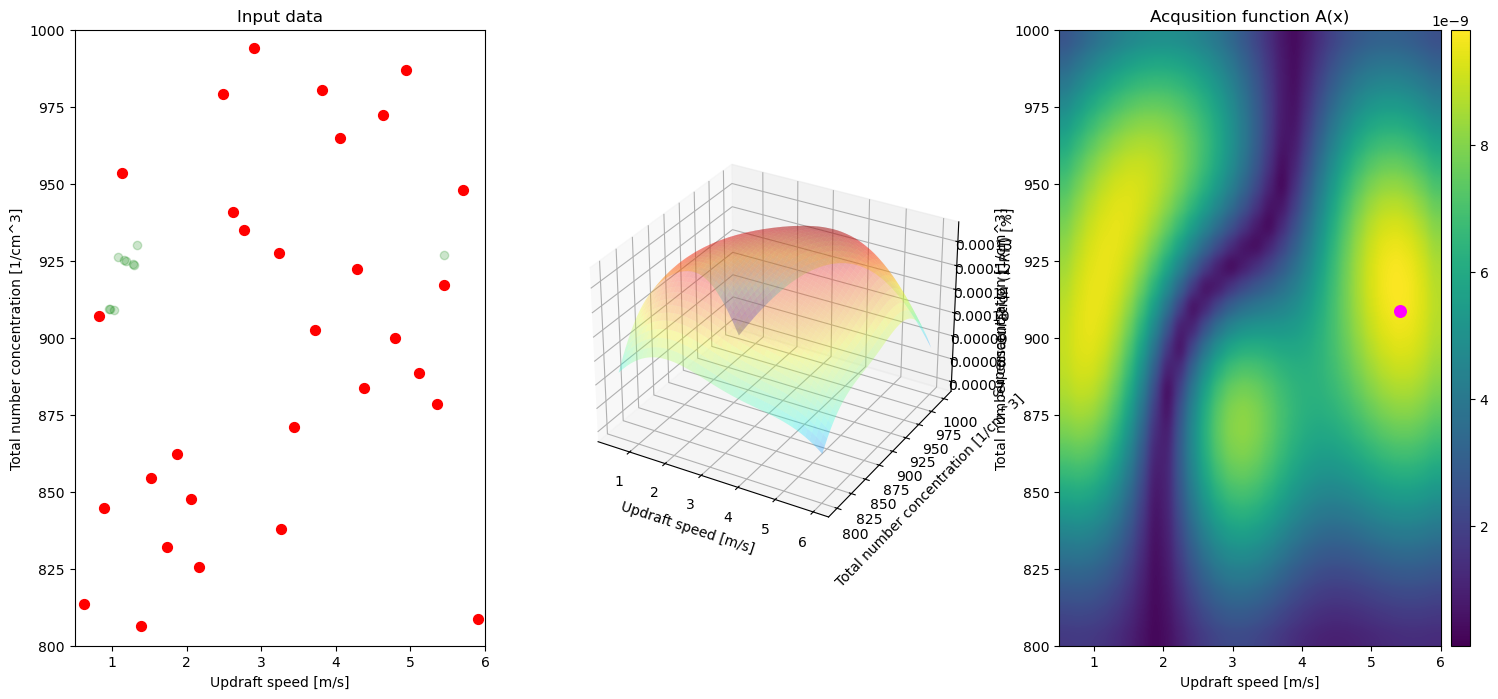

In [10]:
plot_all(limitscale)

In [90]:
amo.data['X'].shape

(75, 2)

In [66]:
means=np.array([np.mean(Xt[:,0]),np.mean(Xt[:,1])]); stdevs=np.array([np.std(Xt[:,0]),np.std(Xt[:,1])])
print(means, stdevs)

[  3.23774889 899.80203011] [ 1.59028434 57.58349068]


In [70]:
amo.means = np.array([np.mean(amo.data['X'][:,0]),np.mean(amo.data['X'][:,1])]); 
amo.stdevs = np.array([np.std(amo.data['X'][:,0]),np.std(amo.data['X'][:,1])])
print(amo.means, amo.stdevs)

[  2.77469591 901.70959248] [ 1.4711148  43.43206392]
